In [1]:
import pandas as pd 
import numpy as np 

In [4]:
hdf = pd.HDFStore('output/pipeline.h5')

In [5]:
hdf.keys()

['/checkpoints']

In [6]:
hdf['/checkpoints']

,checkpoint_name,timestamp
0,init,2021-05-11 20:55:25.188966
1,create_inputs_from_usim_data,2021-05-11 20:55:25.200510


In [7]:
plans = hdf['/plans']
trips = hdf['/trips']
tours = hdf['/tours']

In [8]:
def generate_departure_times(trips, tours):

    trips["inbound"] = ~trips.outbound
    trips["tour_start"] = trips.tour_id.map(tours.start)
    trips["tour_end"] = trips.tour_id.map(tours.end)

    # TO DO: fractional times must respect the original order of trips!!!!
    df = trips[[
        'person_id', 'depart', 'tour_start', 'tour_end', 'tour_id', 'inbound',
        'trip_num']].reset_index().drop_duplicates('trip_id')
    df['frac'] = np.random.rand(len(df),)
    df.index.name = 'og_df_idx'

    # Making sure trips within the hour are sequential
    ordered_trips = df.sort_values(by=[
        'person_id', 'depart', 'frac', 'tour_start', 'tour_end', 'tour_id',
        'inbound', 'trip_num']).reset_index()
    df2 = df.sort_values(by=[
        'person_id', 'depart', 'tour_start', 'tour_end',
        'tour_id', 'inbound', 'trip_num']).reset_index()
    df2['fractional'] = ordered_trips.frac

    # Adding fractional to int hour
    df2['depart'] = np.round(df2['depart'] + df2['fractional'], 3)
    df2.set_index('og_df_idx', inplace=True)
    df2 = df2.reindex(df.index)
    df2.set_index('trip_id', inplace=True)
    df2 = df2.reindex(trips.index)
    return df2.depart

In [22]:
trips.columns

Index(['person_id', 'household_id', 'tour_id', 'primary_purpose', 'trip_num',
       'outbound', 'trip_count', 'purpose', 'destination', 'origin',
       'destination_logsum', 'depart', 'trip_mode', 'mode_choice_logsum',
       'inbound', 'tour_start', 'tour_end'],
      dtype='object')

In [23]:
trips['departure_time_mins'] = generate_departure_times(trips, tours)

In [27]:
trips.trip_mode.unique()
car_modes = ['SHARED2FREE', 'SHARED2PAY', 'SHARED3FREE', 'DRIVEALONEFREE',
       'DRIVEALONEPAY','SHARED3PAY', 'TAXI',
       'TNC_SHARED', 'TNC_SINGLE']

In [29]:
car_trips = trips[trips.trip_mode.isin(car_modes)]

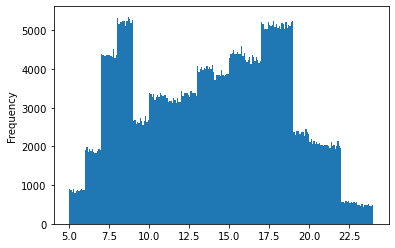

In [42]:
car_trips['departure_time_mins'].plot.hist(bins = 228).get_figure().savefig('departure_time_cars.jpeg')

<AxesSubplot:ylabel='Frequency'>

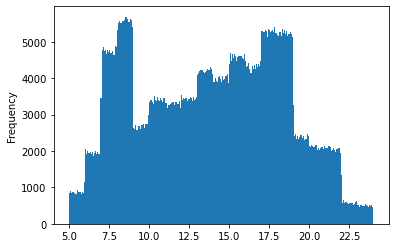

In [21]:
trips2.plot.hist(bins = 280)

<AxesSubplot:ylabel='Frequency'>

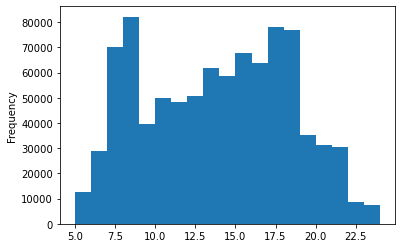

In [25]:
trips2.plot.hist(bins = 19)

5.0